In [1]:
# Import libraries
import sys

import networkx as nx
import pandas as pd
import numpy as np
import os

import stellargraph as sg
from stellargraph import StellarGraph
from stellargraph.mapper import GraphSAGENodeGenerator, FullBatchNodeGenerator
from stellargraph.layer import GraphSAGE, GCN

import tensorflow as tf
from tensorflow import keras
from keras import layers, optimizers, losses, metrics, Model
from sklearn import preprocessing, feature_extraction, model_selection

import json

In [ ]:
# Setup GPU

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

## Load Data and Preprocessing

In [2]:
# Import dataset
G = nx.read_graphml( "data/citeseer/citeseer.graphml" )

print(G) # should be 3312 nodes and 4715 edges

DiGraph with 3312 nodes and 4715 edges


In [3]:
G.graph

{'node_default': {}, 'edge_default': {}}

In [4]:
print( json.dumps( list( G.nodes(data=True) )[0], indent = 4 ) ) # 1-1432: weights, 1433: subject

[
    "100157",
    {
        "w_0": 0,
        "w_1": 0,
        "w_2": 0,
        "w_3": 0,
        "w_4": 0,
        "w_5": 0,
        "w_6": 0,
        "w_7": 0,
        "w_8": 0,
        "w_9": 0,
        "w_10": 0,
        "w_11": 0,
        "w_12": 0,
        "w_13": 0,
        "w_14": 0,
        "w_15": 0,
        "w_16": 0,
        "w_17": 0,
        "w_18": 0,
        "w_19": 0,
        "w_20": 0,
        "w_21": 0,
        "w_22": 0,
        "w_23": 0,
        "w_24": 0,
        "w_25": 0,
        "w_26": 0,
        "w_27": 0,
        "w_28": 0,
        "w_29": 0,
        "w_30": 0,
        "w_31": 0,
        "w_32": 0,
        "w_33": 0,
        "w_34": 0,
        "w_35": 0,
        "w_36": 1,
        "w_37": 0,
        "w_38": 0,
        "w_39": 0,
        "w_40": 0,
        "w_41": 0,
        "w_42": 0,
        "w_43": 0,
        "w_44": 0,
        "w_45": 0,
        "w_46": 1,
        "w_47": 0,
        "w_48": 0,
        "w_49": 0,
        "w_50": 0,
        "w_51": 0,


In [5]:
for node in G.nodes():
    print( G.nodes[node]['subject'] )
    break

Agents


In [6]:
# for each node, encode weight as a feature
for node in G.nodes():
    enc = [ val for key, val in G.nodes[node].items() if key != 'subject' and key != 'label' ]
    G.nodes[node]['feature'] = enc

In [7]:
for node in G.nodes( data=True ):
    print( node )
    break

('100157', {'w_0': 0, 'w_1': 0, 'w_2': 0, 'w_3': 0, 'w_4': 0, 'w_5': 0, 'w_6': 0, 'w_7': 0, 'w_8': 0, 'w_9': 0, 'w_10': 0, 'w_11': 0, 'w_12': 0, 'w_13': 0, 'w_14': 0, 'w_15': 0, 'w_16': 0, 'w_17': 0, 'w_18': 0, 'w_19': 0, 'w_20': 0, 'w_21': 0, 'w_22': 0, 'w_23': 0, 'w_24': 0, 'w_25': 0, 'w_26': 0, 'w_27': 0, 'w_28': 0, 'w_29': 0, 'w_30': 0, 'w_31': 0, 'w_32': 0, 'w_33': 0, 'w_34': 0, 'w_35': 0, 'w_36': 1, 'w_37': 0, 'w_38': 0, 'w_39': 0, 'w_40': 0, 'w_41': 0, 'w_42': 0, 'w_43': 0, 'w_44': 0, 'w_45': 0, 'w_46': 1, 'w_47': 0, 'w_48': 0, 'w_49': 0, 'w_50': 0, 'w_51': 0, 'w_52': 0, 'w_53': 0, 'w_54': 0, 'w_55': 0, 'w_56': 0, 'w_57': 0, 'w_58': 0, 'w_59': 0, 'w_60': 0, 'w_61': 0, 'w_62': 0, 'w_63': 0, 'w_64': 0, 'w_65': 1, 'w_66': 0, 'w_67': 0, 'w_68': 0, 'w_69': 0, 'w_70': 0, 'w_71': 0, 'w_72': 0, 'w_73': 0, 'w_74': 0, 'w_75': 0, 'w_76': 0, 'w_77': 0, 'w_78': 0, 'w_79': 0, 'w_80': 0, 'w_81': 0, 'w_82': 0, 'w_83': 0, 'w_84': 0, 'w_85': 0, 'w_86': 0, 'w_87': 0, 'w_88': 0, 'w_89': 0, 'w_90': 

In [8]:
# copy graph
from copy import deepcopy
G2 = deepcopy(G)

# remove redundant weight attributes from nodes
for node in G2.nodes():
    for key in G2.nodes[node].keys():
        if key != 'subject' and key != 'label' and key != 'feature':
            G.nodes[node].pop(key)

del G2

In [9]:
# print node attributes
for node in G.nodes( data=True ):
    print( node )
    break

('100157', {'subject': 'Agents', 'feature': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

In [10]:
print( json.dumps( list( G.nodes(data=True) )[0], indent = 4 ) )

[
    "100157",
    {
        "subject": "Agents",
        "feature": [
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            1,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            1,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0

In [11]:
print( json.dumps( list( G.edges(data=True) )[0:10], indent = 4 ) )

[
    [
        "100157",
        "100157",
        {
            "label": "cites"
        }
    ],
    [
        "364207",
        "100157",
        {
            "label": "cites"
        }
    ],
    [
        "38848",
        "100157",
        {
            "label": "cites"
        }
    ],
    [
        "bradshaw97introduction",
        "100157",
        {
            "label": "cites"
        }
    ],
    [
        "bylund99coordinating",
        "100157",
        {
            "label": "cites"
        }
    ],
    [
        "bylund99coordinating",
        "waern98concall",
        {
            "label": "cites"
        }
    ],
    [
        "dix01metaagent",
        "100157",
        {
            "label": "cites"
        }
    ],
    [
        "dix01metaagent",
        "4664",
        {
            "label": "cites"
        }
    ],
    [
        "dix01metaagent",
        "arisha99impact",
        {
            "label": "cites"
        }
    ],
    [
        "dix01metaagent",
   

## Create StellarGraph

In [12]:
SG = StellarGraph.from_networkx(
    graph=G, node_type_default="subject", node_features="feature"
)

print( SG.info() )

StellarDiGraph: Directed multigraph
 Nodes: 3312, Edges: 4715

 Node types:
  subject: [3312]
    Features: float32 vector, length 3703
    Edge types: subject-cites->subject

 Edge types:
    subject-cites->subject: [4715]
        Weights: all 1 (default)
        Features: none


In [13]:
# create a node_subjects Pandas Series with node IDs as index and subject as value
node_subjects = pd.Series( [ G.nodes[node]['subject'] for node in G.nodes() ], index = G.nodes() )
print( node_subjects.head() )

100157                    Agents
364207                    Agents
38848                     Agents
bradshaw97introduction       HCI
bylund99coordinating         HCI
dtype: object


In [14]:
# split into train and test sets
train_subjects, test_subjects = model_selection.train_test_split(
    node_subjects, train_size=0.7, test_size=None, stratify=node_subjects
)

print( train_subjects )

454876                         IR
duch00computational            IR
bruderlin97hierarchical    Agents
104129                         IR
64654                          ML
                            ...  
subramanian98costbased         DB
li01minimizing                 DB
531754                     Agents
kang00visualization           HCI
calvanese01description         DB
Length: 2318, dtype: object


In [15]:
from collections import Counter
Counter(train_subjects) # consider imbalance between class

Counter({'IR': 467,
         'Agents': 417,
         'ML': 413,
         'DB': 491,
         'AI': 174,
         'HCI': 356})

In [16]:
# Convert to numeric labels
le = preprocessing.LabelBinarizer()
train_targets = le.fit_transform(train_subjects)
test_targets = le.transform(test_subjects)

In [17]:
print( train_targets ) # for each node, the subject is encoded as a number

[[0 0 0 0 1 0]
 [0 0 0 0 1 0]
 [0 1 0 0 0 0]
 ...
 [0 1 0 0 0 0]
 [0 0 0 1 0 0]
 [0 0 1 0 0 0]]


## Define benchmarking metrics

In [ ]:
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support, roc_auc_score


def benchmarking_result( targets, predictions ) :
    # Accuracy
    train_acc = np.mean( targets == predictions )

    # Confusion matrix
    # cm = confusion_matrix( targets, predictions )

    # Precision, recall, f1-score
    precision, recall, f1, _ = precision_recall_fscore_support( targets, predictions, average='micro' )

    # AUC-ROC
    # auc = roc_auc_score( targets, predictions )

    return train_acc, precision, recall, f1


## GraphSAGE model

In [18]:
batch_size = 50
num_samples = [10, 10, 5]

generator = GraphSAGENodeGenerator( SG, batch_size, num_samples )

In [19]:
train_gen = generator.flow( train_subjects.index, train_targets, shuffle = True )

In [20]:
graphsage_model = GraphSAGE(
    layer_sizes=[32, 32, 16], generator=generator, bias=True, dropout=0.5
)

In [21]:
print( train_targets.shape )

(2318, 6)


In [22]:
x_inp, x_out = graphsage_model.in_out_tensors()
prediction = layers.Dense(units=train_targets.shape[1], activation="softmax")(x_out)

### Train model

In [23]:
model = Model(inputs=x_inp, outputs=prediction)
model.compile(
    optimizer=optimizers.Adam( learning_rate=0.005 ),
    loss=losses.categorical_crossentropy,
    metrics=["acc"],
)

In [24]:
test_gen = generator.flow(test_subjects.index, test_targets)

In [25]:
history = model.fit(
    train_gen, epochs=20, validation_data=test_gen, verbose=2, shuffle=False
)

Epoch 1/20
47/47 - 63s - loss: 1.4313 - acc: 0.5522 - val_loss: 1.0972 - val_acc: 0.7153 - 63s/epoch - 1s/step
Epoch 2/20
47/47 - 30s - loss: 0.9502 - acc: 0.7718 - val_loss: 0.9224 - val_acc: 0.7264 - 30s/epoch - 637ms/step
Epoch 3/20
47/47 - 31s - loss: 0.7149 - acc: 0.8162 - val_loss: 0.8776 - val_acc: 0.7384 - 31s/epoch - 660ms/step
Epoch 4/20
47/47 - 29s - loss: 0.5909 - acc: 0.8430 - val_loss: 0.8886 - val_acc: 0.7294 - 29s/epoch - 619ms/step
Epoch 5/20
47/47 - 30s - loss: 0.5174 - acc: 0.8568 - val_loss: 0.8924 - val_acc: 0.7304 - 30s/epoch - 633ms/step
Epoch 6/20
47/47 - 30s - loss: 0.4637 - acc: 0.8676 - val_loss: 0.9250 - val_acc: 0.7193 - 30s/epoch - 637ms/step
Epoch 7/20
47/47 - 31s - loss: 0.4098 - acc: 0.8779 - val_loss: 0.9632 - val_acc: 0.7233 - 31s/epoch - 658ms/step
Epoch 8/20
47/47 - 29s - loss: 0.3813 - acc: 0.8874 - val_loss: 0.9624 - val_acc: 0.7243 - 29s/epoch - 620ms/step
Epoch 9/20
47/47 - 31s - loss: 0.3493 - acc: 0.8939 - val_loss: 1.0054 - val_acc: 0.7163 - 

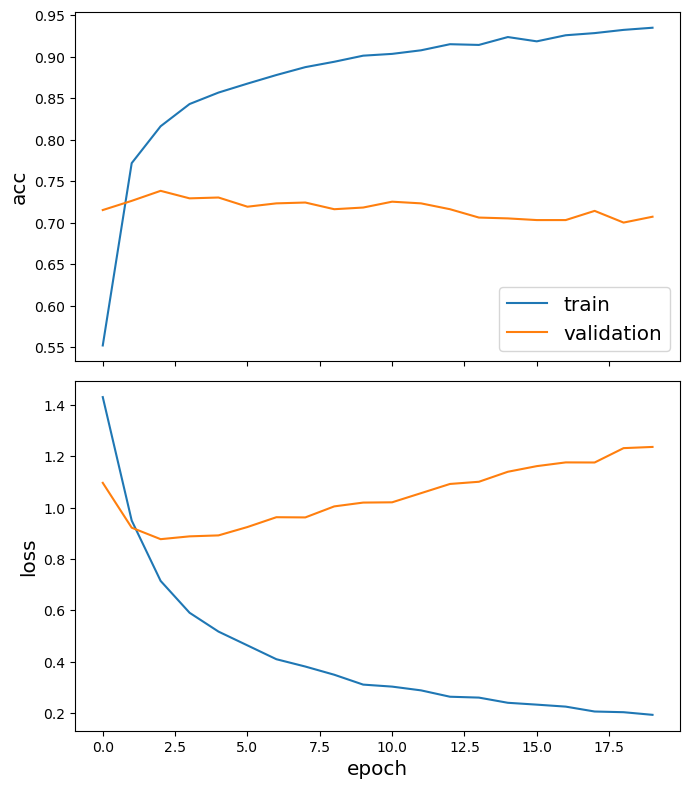

In [26]:
sg.utils.plot_history(history)

In [27]:
test_metrics = model.evaluate(test_gen)
print("\nTest Set Metrics:")
for name, val in zip(model.metrics_names, test_metrics):
    print("\t{}: {:0.4f}".format(name, val))

20/20 [==============================] - 6s 310ms/step - loss: 1.2261 - acc: 0.7113

Test Set Metrics:
	loss: 1.2261
	acc: 0.7113


### Benchmark model

In [ ]:
# print benchmarking results
targets = np.argmax( test_targets, axis=1 )
predictions = np.argmax( model.predict(test_gen), axis=1 )

In [ ]:
train_acc, precision, recall, f1 = benchmarking_result( targets, predictions )

print( "Accuracy: ", train_acc )
print( "Precision: ", precision )
print( "Recall: ", recall )
print( "F1: ", f1 )

# this result is wrong

In [ ]:
all_nodes = node_subjects.index
all_mapper = generator.flow(all_nodes)
all_predictions = model.predict(all_mapper)

In [ ]:
node_predictions = le.inverse_transform(all_predictions)

In [ ]:
df = pd.DataFrame({"Predicted": node_predictions, "True": node_subjects})
df.head(10)

In [ ]:
# calculate accuracy
df['Correct'] = df['Predicted'] == df['True']
df['Correct'].value_counts()

In [ ]:
accuracy = df['Correct'].value_counts()[True] / df['Correct'].value_counts().sum()
print( accuracy )

## GCN model

In [30]:
train_subjects, test_subjects = model_selection.train_test_split(
    node_subjects, train_size=0.7, test_size=None, stratify=node_subjects, random_state=42
)

val_subjects, test_subjects = model_selection.train_test_split(
    test_subjects, train_size=0.5, test_size=None, stratify=test_subjects
)

In [31]:
train_subjects.value_counts().to_frame() # why is equal to demo?

,0
DB,491
IR,467
Agents,417
ML,413
HCI,356
AI,174


In [32]:
# Convert to numeric labels
le = preprocessing.LabelBinarizer()
train_targets = le.fit_transform(train_subjects)
val_targets = le.transform(val_subjects)
test_targets = le.transform(test_subjects)

In [33]:
generator = FullBatchNodeGenerator(SG, method="gcn")

Using GCN (local pooling) filters...


In [34]:
train_gen = generator.flow(train_subjects.index, train_targets)

In [35]:
gcn = GCN(
    layer_sizes=[16, 16], activations=["relu", "relu"], generator=generator, dropout=0.5
)

In [36]:
x_inp, x_out = gcn.in_out_tensors()

In [37]:
predictions = layers.Dense(units=train_targets.shape[1], activation="softmax")(x_out)

### Train model

In [38]:
model = Model(inputs=x_inp, outputs=predictions)
model.compile(
    optimizer=optimizers.Adam( learning_rate=0.005 ),
    loss=losses.categorical_crossentropy,
    metrics=["acc"],
)

In [39]:
val_gen = generator.flow(val_subjects.index, val_targets)

In [40]:
from tensorflow.keras.callbacks import EarlyStopping

es_callback = EarlyStopping(monitor="val_acc", patience=50, restore_best_weights=True)

In [41]:
history = model.fit(
    train_gen,
    epochs=200,
    validation_data=val_gen,
    verbose=2,
    shuffle=False,  # this should be False, since shuffling data means shuffling the whole graph
    callbacks=[es_callback],
)

Epoch 1/200
1/1 - 1s - loss: 1.7969 - acc: 0.1437 - val_loss: 1.7706 - val_acc: 0.2495 - 901ms/epoch - 901ms/step
Epoch 2/200
1/1 - 0s - loss: 1.7610 - acc: 0.2580 - val_loss: 1.7346 - val_acc: 0.3501 - 125ms/epoch - 125ms/step
Epoch 3/200
1/1 - 0s - loss: 1.7255 - acc: 0.3352 - val_loss: 1.6803 - val_acc: 0.4547 - 125ms/epoch - 125ms/step
Epoch 4/200
1/1 - 0s - loss: 1.6716 - acc: 0.4323 - val_loss: 1.6167 - val_acc: 0.5111 - 122ms/epoch - 122ms/step
Epoch 5/200
1/1 - 0s - loss: 1.6073 - acc: 0.4681 - val_loss: 1.5504 - val_acc: 0.5332 - 128ms/epoch - 128ms/step
Epoch 6/200
1/1 - 0s - loss: 1.5333 - acc: 0.5246 - val_loss: 1.4839 - val_acc: 0.5453 - 133ms/epoch - 133ms/step
Epoch 7/200
1/1 - 0s - loss: 1.4689 - acc: 0.5358 - val_loss: 1.4188 - val_acc: 0.5614 - 134ms/epoch - 134ms/step
Epoch 8/200
1/1 - 0s - loss: 1.4069 - acc: 0.5371 - val_loss: 1.3566 - val_acc: 0.5875 - 129ms/epoch - 129ms/step
Epoch 9/200
1/1 - 0s - loss: 1.3516 - acc: 0.5561 - val_loss: 1.2982 - val_acc: 0.6137 -

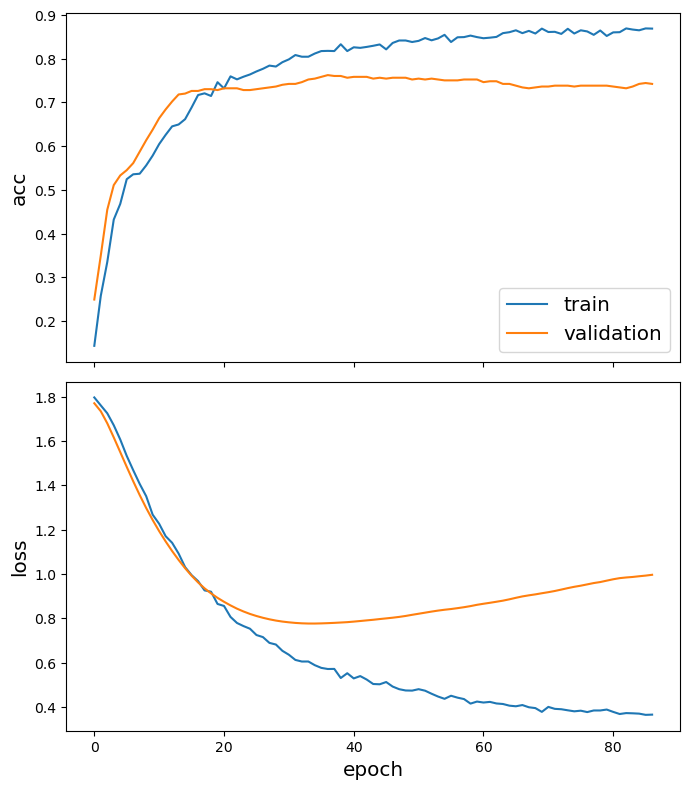

In [42]:
sg.utils.plot_history(history)

In [43]:
test_gen = generator.flow(test_subjects.index, test_targets)

In [44]:
test_metrics = model.evaluate(test_gen)
print("\nTest Set Metrics:")
for name, val in zip(model.metrics_names, test_metrics):
    print("\t{}: {:0.4f}".format(name, val))

1/1 [==============================] - 0s 48ms/step - loss: 0.7102 - acc: 0.7907

Test Set Metrics:
	loss: 0.7102
	acc: 0.7907


# GAT model

In [66]:
from stellargraph.mapper import FullBatchNodeGenerator
from stellargraph.layer import GAT

In [67]:
# split data
train_subjects, test_subjects = model_selection.train_test_split(
    node_subjects, train_size=0.7, test_size=None, stratify=node_subjects
)

val_subjects, test_subjects = model_selection.train_test_split(
    test_subjects, train_size=0.5, test_size=None, stratify=test_subjects
)

In [68]:
from collections import Counter

Counter(train_subjects)

Counter({'IR': 467,
         'ML': 413,
         'DB': 491,
         'Agents': 417,
         'HCI': 356,
         'AI': 174})

In [69]:
# Convert to numeric labels
le = preprocessing.LabelBinarizer()
train_targets = le.fit_transform(train_subjects)
val_targets = le.transform(val_subjects)
test_targets = le.transform(test_subjects)

In [70]:
# Create the GAT model
generator = FullBatchNodeGenerator(SG, method="gat")
train_gen = generator.flow(train_subjects.index, train_targets)

In [71]:
gat = GAT(
    layer_sizes=[16, 16],
    activations=["elu", "elu"],
    attn_heads=8,
    generator=generator,
    in_dropout=0.5,
    attn_dropout=0.5,
    normalize=None,
)

In [72]:
x_inp, x_out = gat.in_out_tensors()
predictions = layers.Dense(units=train_targets.shape[1], activation="softmax")(x_out)

In [73]:
model = Model(inputs=x_inp, outputs= predictions)
model.compile(
    optimizer=optimizers.Adam( learning_rate=0.005 ),
    loss=losses.categorical_crossentropy,
    metrics=["acc"],
)

In [74]:
val_gen = generator.flow(val_subjects.index, val_targets)

In [75]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

if not os.path.isdir("logs"):
    os.makedirs("logs")
es_callback = EarlyStopping(
    monitor="val_acc", patience=20
)  # patience is the number of epochs to wait before early stopping in case of no further improvement
mc_callback = ModelCheckpoint(
    "logs/best_model.h5", monitor="val_acc", save_best_only=True, save_weights_only=True
)

Epoch 1/200
1/1 - 3s - loss: 1.9316 - acc: 0.1553 - val_loss: 1.5250 - val_acc: 0.5775 - 3s/epoch - 3s/step
Epoch 2/200
1/1 - 0s - loss: 1.6469 - acc: 0.3525 - val_loss: 1.3243 - val_acc: 0.6942 - 181ms/epoch - 181ms/step
Epoch 3/200
1/1 - 0s - loss: 1.4331 - acc: 0.5035 - val_loss: 1.1645 - val_acc: 0.7284 - 203ms/epoch - 203ms/step
Epoch 4/200
1/1 - 0s - loss: 1.2863 - acc: 0.5811 - val_loss: 1.0427 - val_acc: 0.7264 - 168ms/epoch - 168ms/step
Epoch 5/200
1/1 - 0s - loss: 1.1700 - acc: 0.6260 - val_loss: 0.9533 - val_acc: 0.7304 - 219ms/epoch - 219ms/step
Epoch 6/200
1/1 - 0s - loss: 1.0931 - acc: 0.6368 - val_loss: 0.8889 - val_acc: 0.7445 - 190ms/epoch - 190ms/step
Epoch 7/200
1/1 - 0s - loss: 1.0222 - acc: 0.6743 - val_loss: 0.8449 - val_acc: 0.7485 - 203ms/epoch - 203ms/step
Epoch 8/200
1/1 - 0s - loss: 0.9977 - acc: 0.6838 - val_loss: 0.8145 - val_acc: 0.7485 - 172ms/epoch - 172ms/step
Epoch 9/200
1/1 - 0s - loss: 0.9402 - acc: 0.7049 - val_loss: 0.7946 - val_acc: 0.7465 - 165ms

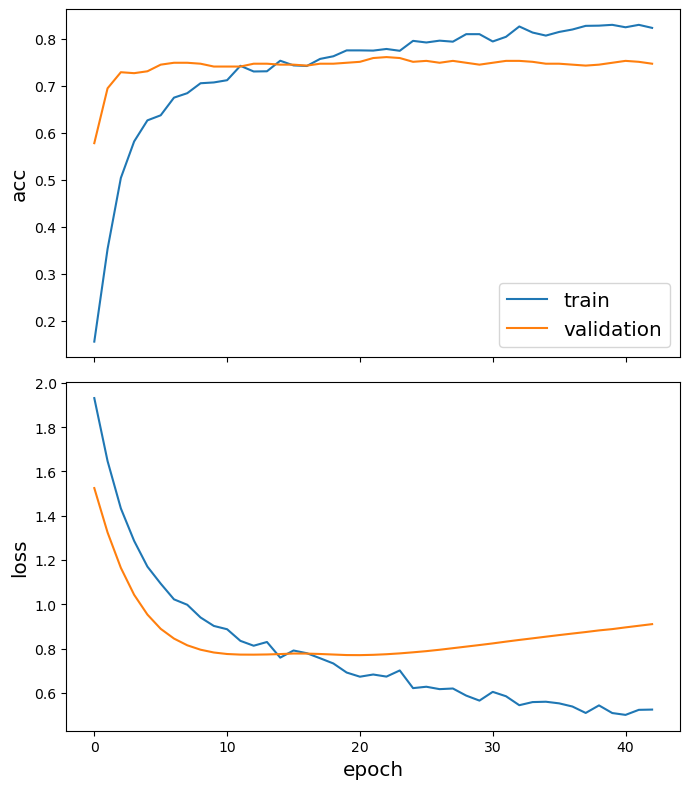

In [76]:
history = model.fit(
    train_gen,
    epochs=200,
    validation_data=val_gen,
    verbose=2,
    shuffle=False,  # this should be False, since shuffling data means shuffling the whole graph
    callbacks=[es_callback, mc_callback],
)
sg.utils.plot_history(history)


In [77]:
model.load_weights("logs/best_model.h5")
test_gen = generator.flow(test_subjects.index, test_targets)
test_metrics = model.evaluate(test_gen)
print("\nTest Set Metrics:")
for name, val in zip(model.metrics_names, test_metrics):
    print("\t{}: {:0.4f}".format(name, val))

1/1 [==============================] - 0s 49ms/step - loss: 0.7749 - acc: 0.7767

Test Set Metrics:
	loss: 0.7749
	acc: 0.7767
